В настоящем проекте необходимо использовать базу акций Лукойла.

Сделаем несколько усовершенствований в предсказании временного ряда.
Добавим к исходному сигналу расширенные данные:

* попарные разности каналов
* модули попарных разностей каналов
* попарные произведения каналов
* обратное значение каналов x_new = 1/(x + 1e-3)
* первые производные каналов (x[n] - x[n-1])
* вторые производные каналов (x[n] - 2*x[n-1] + x[n-2])

Сделаем бОльший “просмотр сети в прошлое”, при формировании входного сигнала используем:

* 100 точек с шагом назад по 1,

* 100 точек с шагом назад по 10 (или сами точки, или среднее по отрезку в 10 точек).

Модели считаются довольно долго

## Подготовка

In [64]:
# Работа с массивами
import numpy as np

# Работа с таблицами
import pandas as pd

# Классы-конструкторы моделей нейронных сетей
from tensorflow.keras.models import Sequential, Model

# Основные слои
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, LSTM, MaxPooling1D

# Оптимизаторы
from tensorflow.keras.optimizers import Adam

# Генератор выборки временных рядов
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

# Нормировщики
from sklearn.preprocessing import StandardScaler, MinMaxScaler 

# Коллбэк
from tensorflow.keras.callbacks import LearningRateScheduler

# Загрузка датасетов из облака google
import gdown

# Отрисовка графиков
import matplotlib.pyplot as plt

# Отрисовка графики в ячейке colab
%matplotlib inline

# Отключение предупреждений
import warnings
warnings.filterwarnings('ignore')

In [65]:
# Назначение размера и стиля графиков по умолчанию

from pylab import rcParams
plt.style.use('ggplot')
rcParams['figure.figsize'] = (14, 7)

In [66]:
# Загрузка датасетов из облака

gdown.download('https://storage.googleapis.com/datasets_ai/Base/11_timeseries/16_17.csv', None, quiet=True)
gdown.download('https://storage.googleapis.com/datasets_ai/Base/11_timeseries/18_19.csv', None, quiet=True)

'18_19.csv'

In [67]:
# Чтение данных в таблицы с удалением ненужных столбцов

data16_17 = pd.read_csv('16_17.csv', sep=';').drop(columns=['DATE', 'TIME'])
data18_19 = pd.read_csv('18_19.csv', sep=';').drop(columns=['DATE', 'TIME'])

In [68]:
# Просмотр размерностей получившихся таблиц

print(data16_17.shape)
print(data18_19.shape)

(263925, 5)
(217947, 5)


In [69]:
data16_17

,OPEN,MAX,MIN,CLOSE,VOLUME
0,2351.0,2355.8,2350.0,2350.0,2547
1,2352.9,2355.7,2350.0,2355.7,195
2,2355.6,2356.0,2351.4,2354.1,257
3,2354.5,2355.0,2351.2,2353.7,763
4,2353.1,2353.9,2353.1,2353.6,231
...,...,...,...,...,...
263920,3320.5,3322.0,3316.5,3317.0,1227
263921,3318.0,3323.5,3317.0,3323.5,938
263922,3323.0,3324.0,3314.5,3314.5,1996
263923,3334.5,3334.5,3334.5,3334.5,83877


In [70]:
# Создание общего набора данных из двух датасетов

data = pd.concat([data16_17,data18_19])   # Объединение датасетов
data = data.reset_index(drop = True)      # Обнуление индексов

# Проверка формы данных 
print(data.shape) 

(481872, 5)


In [71]:
# Получение названий столбцов

col = data.columns
print(col) 

Index(['OPEN', 'MAX', 'MIN', 'CLOSE', 'VOLUME'], dtype='object')


In [72]:
data

,OPEN,MAX,MIN,CLOSE,VOLUME
0,2351.0,2355.8,2350.0,2350.0,2547
1,2352.9,2355.7,2350.0,2355.7,195
2,2355.6,2356.0,2351.4,2354.1,257
3,2354.5,2355.0,2351.2,2353.7,763
4,2353.1,2353.9,2353.1,2353.6,231
...,...,...,...,...,...
481867,5183.5,5183.5,5183.5,5183.5,31523
481868,5183.5,5183.5,5183.5,5183.5,5090
481869,5183.5,5183.5,5183.5,5183.5,230
481870,5183.5,5183.5,5183.5,5183.5,5


In [73]:
# Задание циклов для столбцов таким образом, чтобы происходил перебор всех возможных пар:
# Перебор индексов массива с именами столбцов 'OPEN', 'MAX', 'MIN', 'CLOSE', 'VOLUME', 
# получая пары 'OPEN' и 'MAX', 'OPEN' и 'MIN', 'OPEN' и 'CLOSE' ..., 'MAX' и 'MIN', 'MAX' и 'CLOSE' и т.д

for i in range(col.shape[0]): # Для всех пар
    for j in range(i + 1 , col.shape[0]): # Расчет
        data[col[i] + '-' + col[j]] = data[col[i]] - data[col[j]] # Разности
        data['|' + col[i] + '-' + col[j] + '|'] = abs(data[col[i]] - data[col[j]]) # Модулей разностей
        data[col[i] + '*' + col[j]] = data[col[i]] * data[col[j]] # Произведения

# Для каждого столбца 'OPEN', 'MAX', 'MIN', 'CLOSE', 'VOLUME' расчет:
for i in col:
    # Обратные значения. 1e-3 в формуле нужно, чтобы случайно не разделить на 0
    data['Обратный ' + i] = 1 / (data[i] + 1e-3) 
    # Создание пустого столбца
    data['Производная от ' + i] = np.nan 
    # При помощи срезов расчет первых производных, .reset_index(drop=True) нужен для корректных расчетов
    data['Производная от ' + i][1:] = data[i][1:].reset_index(drop=True) - data[i][:-1].reset_index(drop=True) 
    # Создание пустого столбца
    data['Вторая производная от ' + i] = np.nan  
    # При помощи срезов расчет вторых производных
    data['Вторая производная от ' + i][2:] = data[i][2:].reset_index(drop=True) - 2 * data[i][1:-1].reset_index(drop=True) + data[i][:-2].reset_index(drop=True)  


In [74]:
# Просмотр результатов
data

,OPEN,MAX,MIN,CLOSE,VOLUME,OPEN-MAX,|OPEN-MAX|,OPEN*MAX,OPEN-MIN,|OPEN-MIN|,OPEN*MIN,OPEN-CLOSE,|OPEN-CLOSE|,OPEN*CLOSE,OPEN-VOLUME,|OPEN-VOLUME|,OPEN*VOLUME,MAX-MIN,|MAX-MIN|,MAX*MIN,MAX-CLOSE,|MAX-CLOSE|,MAX*CLOSE,MAX-VOLUME,|MAX-VOLUME|,MAX*VOLUME,MIN-CLOSE,|MIN-CLOSE|,MIN*CLOSE,MIN-VOLUME,|MIN-VOLUME|,MIN*VOLUME,CLOSE-VOLUME,|CLOSE-VOLUME|,CLOSE*VOLUME,Обратный OPEN,Производная от OPEN,Вторая производная от OPEN,Обратный MAX,Производная от MAX,Вторая производная от MAX,Обратный MIN,Производная от MIN,Вторая производная от MIN,Обратный CLOSE,Производная от CLOSE,Вторая производная от CLOSE,Обратный VOLUME,Производная от VOLUME,Вторая производная от VOLUME
0,2351.0,2355.8,2350.0,2350.0,2547,-4.8,4.8,5538485.80,1.0,1.0,5524850.00,1.0,1.0,5524850.00,-196.0,196.0,5987997.0,5.8,5.8,5536130.00,5.8,5.8,5536130.00,-191.2,191.2,6000222.6,0.0,0.0,5522500.00,-197.0,197.0,5985450.0,-197.0,197.0,5985450.0,0.000425,NaN,NaN,0.000424,NaN,NaN,0.000426,NaN,NaN,0.000426,NaN,NaN,0.000393,NaN,NaN
1,2352.9,2355.7,2350.0,2355.7,195,-2.8,2.8,5542726.53,2.9,2.9,5529315.00,-2.8,2.8,5542726.53,2157.9,2157.9,458815.5,5.7,5.7,5535895.00,0.0,0.0,5549322.49,2160.7,2160.7,459361.5,-5.7,5.7,5535895.00,2155.0,2155.0,458250.0,2160.7,2160.7,459361.5,0.000425,1.9,NaN,0.000425,-0.1,NaN,0.000426,0.0,NaN,0.000425,5.7,NaN,0.005128,-2352.0,NaN
2,2355.6,2356.0,2351.4,2354.1,257,-0.4,0.4,5549793.60,4.2,4.2,5538957.84,1.5,1.5,5545317.96,2098.6,2098.6,605389.2,4.6,4.6,5539898.40,1.9,1.9,5546259.60,2099.0,2099.0,605492.0,-2.7,2.7,5535430.74,2094.4,2094.4,604309.8,2097.1,2097.1,605003.7,0.000425,2.7,0.8,0.000424,0.3,0.4,0.000425,1.4,1.4,0.000425,-1.6,-7.3,0.003891,62.0,2414.0
3,2354.5,2355.0,2351.2,2353.7,763,-0.5,0.5,5544847.50,3.3,3.3,5535900.40,0.8,0.8,5541786.65,1591.5,1591.5,1796483.5,3.8,3.8,5537076.00,1.3,1.3,5542963.50,1592.0,1592.0,1796865.0,-2.5,2.5,5534019.44,1588.2,1588.2,1793965.6,1590.7,1590.7,1795873.1,0.000425,-1.1,-3.8,0.000425,-1.0,-1.3,0.000425,-0.2,-1.6,0.000425,-0.4,1.2,0.001311,506.0,444.0
4,2353.1,2353.9,2353.1,2353.6,231,-0.8,0.8,5538962.09,0.0,0.0,5537079.61,-0.5,0.5,5538256.16,2122.1,2122.1,543566.1,0.8,0.8,5538962.09,0.3,0.3,5540139.04,2122.9,2122.9,543750.9,-0.5,0.5,5538256.16,2122.1,2122.1,543566.1,2122.6,2122.6,543681.6,0.000425,-1.4,-0.3,0.000425,-1.1,-0.1,0.000425,1.9,2.1,0.000425,-0.1,0.3,0.004329,-532.0,-1038.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
481867,5183.5,5183.5,5183.5,5183.5,31523,0.0,0.0,26868672.25,0.0,0.0,26868672.25,0.0,0.0,26868672.25,-26339.5,26339.5,163399470.5,0.0,0.0,26868672.25,0.0,0.0,26868672.25,-26339.5,26339.5,163399470.5,0.0,0.0,26868672.25,-26339.5,26339.5,163399470.5,-26339.5,26339.5,163399470.5,0.000193,13.5,13.5,0.000193,11.5,11.5,0.000193,16.0,18.0,0.000193,11.5,10.0,0.000032,29174.0,29480.0
481868,5183.5,5183.5,5183.5,5183.5,5090,0.0,0.0,26868672.25,0.0,0.0,26868672.25,0.0,0.0,26868672.25,93.5,93.5,26384015.0,0.0,0.0,26868672.25,0.0,0.0,26868672.25,93.5,93.5,26384015.0,0.0,0.0,26868672.25,93.5,93.5,26384015.0,93.5,93.5,26384015.0,0.000193,0.0,-13.5,0.000193,0.0,-11.5,0.000193,0.0,-16.0,0.000193,0.0,-11.5,0.000196,-26433.0,-55607.0
481869,5183.5,5183.5,5183.5,5183.5,230,0.0,0.0,26868672.25,0.0,0.0,26868672.25,0.0,0.0,26868672.25,4953.5,4953.5,1192205.0,0.0,0.0,26868672.25,0.0,0.0,26868672.25,4953.5,4953.5,1192205.0,0.0,0.0,26868672.25,4953.5,4953.5,1192205.0,4953.5,4953.5,1192205.0,0.000193,0.0,0.0,0.000193,0.0,0.0,0.000193,0.0,0.0,0.000193,0.0,0.0,0.004348,-4860.0,21573.0
481870,5183.5,5183.5,5183.5,5183.5,5,0.0,0.0,26868672.25,0.0,0.0,26868672.25,0.0,0.0,26868672.25,5178.5,5178.5,25917.5,0.0,0.0,26868672.25,0.0,0.0,26868672.25,5178.5,5178.5,25917.5,0.0,0.0,26868672.25,5178.5,5178.5,25917.5,5178.5,5178.5,25917.5,0.000193,0.0,0.0,0.000193,0.0,0.0,0.000193,0.0,0.0,0.000193,0.0,0.0,0.199960,-225.0,4635.0


In [75]:
# посмотрим, есть ли отсутствующие значения. Если да - удалим их
data.isna().sum().sum()

15

In [76]:
# Удаление строк с неполными данными
#data.dropna(inplace=True)

In [77]:
# Использование всех столбцов, кроме первых двух
data = data.iloc[2:]

# Переменная, для использования одной и той же архитектуры под разные матрицы
columnsamount = data.shape[1] 

In [78]:
# Задание гиперпараметров
#y_data = data['Close']                     # Отбор каналов данных для предсказания
SEQ_LEN = 200                             # Длина прошедших данных для анализа
BATCH_SIZE = 20                           # Объем батча для генератора
TEST_LEN = 30000                          # Объем тестовой выборки
TRAIN_LEN = data.shape[0] - TEST_LEN      # Объем обучающей выборки

In [79]:
# Получение названий столбцов

CHANNEL_NAMES = data.columns
print(CHANNEL_NAMES) 
CHANNEL_INDEX = {name: chan for chan, name in enumerate(CHANNEL_NAMES)}
CHANNEL_X = CHANNEL_NAMES                 # Отбор каналов входных данных
CHANNEL_Y = ['Close']

Index(['OPEN', 'MAX', 'MIN', 'CLOSE', 'VOLUME', 'OPEN-MAX', '|OPEN-MAX|',
       'OPEN*MAX', 'OPEN-MIN', '|OPEN-MIN|', 'OPEN*MIN', 'OPEN-CLOSE',
       '|OPEN-CLOSE|', 'OPEN*CLOSE', 'OPEN-VOLUME', '|OPEN-VOLUME|',
       'OPEN*VOLUME', 'MAX-MIN', '|MAX-MIN|', 'MAX*MIN', 'MAX-CLOSE',
       '|MAX-CLOSE|', 'MAX*CLOSE', 'MAX-VOLUME', '|MAX-VOLUME|', 'MAX*VOLUME',
       'MIN-CLOSE', '|MIN-CLOSE|', 'MIN*CLOSE', 'MIN-VOLUME', '|MIN-VOLUME|',
       'MIN*VOLUME', 'CLOSE-VOLUME', '|CLOSE-VOLUME|', 'CLOSE*VOLUME',
       'Обратный OPEN', 'Производная от OPEN', 'Вторая производная от OPEN',
       'Обратный MAX', 'Производная от MAX', 'Вторая производная от MAX',
       'Обратный MIN', 'Производная от MIN', 'Вторая производная от MIN',
       'Обратный CLOSE', 'Производная от CLOSE', 'Вторая производная от CLOSE',
       'Обратный VOLUME', 'Производная от VOLUME',
       'Вторая производная от VOLUME'],
      dtype='object')


In [80]:
# Перевод в numpy
#data = np.array(data) 

####**Разделение данных на обучающую и проверочную выборки**

In [81]:
data_train, data_test = data[:TRAIN_LEN], data[TRAIN_LEN + 2*SEQ_LEN:]

In [82]:
data_train

,OPEN,MAX,MIN,CLOSE,VOLUME,OPEN-MAX,|OPEN-MAX|,OPEN*MAX,OPEN-MIN,|OPEN-MIN|,OPEN*MIN,OPEN-CLOSE,|OPEN-CLOSE|,OPEN*CLOSE,OPEN-VOLUME,|OPEN-VOLUME|,OPEN*VOLUME,MAX-MIN,|MAX-MIN|,MAX*MIN,MAX-CLOSE,|MAX-CLOSE|,MAX*CLOSE,MAX-VOLUME,|MAX-VOLUME|,MAX*VOLUME,MIN-CLOSE,|MIN-CLOSE|,MIN*CLOSE,MIN-VOLUME,|MIN-VOLUME|,MIN*VOLUME,CLOSE-VOLUME,|CLOSE-VOLUME|,CLOSE*VOLUME,Обратный OPEN,Производная от OPEN,Вторая производная от OPEN,Обратный MAX,Производная от MAX,Вторая производная от MAX,Обратный MIN,Производная от MIN,Вторая производная от MIN,Обратный CLOSE,Производная от CLOSE,Вторая производная от CLOSE,Обратный VOLUME,Производная от VOLUME,Вторая производная от VOLUME
2,2355.6,2356.0,2351.4,2354.1,257,-0.4,0.4,5549793.60,4.2,4.2,5538957.84,1.5,1.5,5545317.96,2098.6,2098.6,605389.2,4.6,4.6,5539898.40,1.9,1.9,5546259.60,2099.0,2099.0,605492.0,-2.7,2.7,5535430.74,2094.4,2094.4,604309.8,2097.1,2097.1,605003.7,0.000425,2.7,0.8,0.000424,0.3,0.4,0.000425,1.4,1.4,0.000425,-1.6,-7.3,0.003891,62.0,2414.0
3,2354.5,2355.0,2351.2,2353.7,763,-0.5,0.5,5544847.50,3.3,3.3,5535900.40,0.8,0.8,5541786.65,1591.5,1591.5,1796483.5,3.8,3.8,5537076.00,1.3,1.3,5542963.50,1592.0,1592.0,1796865.0,-2.5,2.5,5534019.44,1588.2,1588.2,1793965.6,1590.7,1590.7,1795873.1,0.000425,-1.1,-3.8,0.000425,-1.0,-1.3,0.000425,-0.2,-1.6,0.000425,-0.4,1.2,0.001311,506.0,444.0
4,2353.1,2353.9,2353.1,2353.6,231,-0.8,0.8,5538962.09,0.0,0.0,5537079.61,-0.5,0.5,5538256.16,2122.1,2122.1,543566.1,0.8,0.8,5538962.09,0.3,0.3,5540139.04,2122.9,2122.9,543750.9,-0.5,0.5,5538256.16,2122.1,2122.1,543566.1,2122.6,2122.6,543681.6,0.000425,-1.4,-0.3,0.000425,-1.1,-0.1,0.000425,1.9,2.1,0.000425,-0.1,0.3,0.004329,-532.0,-1038.0
5,2351.8,2351.8,2350.0,2350.0,934,0.0,0.0,5530963.24,1.8,1.8,5526730.00,1.8,1.8,5526730.00,1417.8,1417.8,2196581.2,1.8,1.8,5526730.00,1.8,1.8,5526730.00,1417.8,1417.8,2196581.2,0.0,0.0,5522500.00,1416.0,1416.0,2194900.0,1416.0,1416.0,2194900.0,0.000425,-1.3,0.1,0.000425,-2.1,-1.0,0.000426,-3.1,-5.0,0.000426,-3.6,-3.5,0.001071,703.0,1235.0
6,2350.0,2350.0,2346.9,2347.9,948,0.0,0.0,5522500.00,3.1,3.1,5515215.00,2.1,2.1,5517565.00,1402.0,1402.0,2227800.0,3.1,3.1,5515215.00,2.1,2.1,5517565.00,1402.0,1402.0,2227800.0,-1.0,1.0,5510286.51,1398.9,1398.9,2224861.2,1399.9,1399.9,2225809.2,0.000426,-1.8,-0.5,0.000426,-1.8,0.3,0.000426,-3.1,0.0,0.000426,-2.1,1.5,0.001055,14.0,-689.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
451867,5187.0,5188.5,5186.0,5188.0,354,-1.5,1.5,26912749.50,1.0,1.0,26899782.00,-1.0,1.0,26910156.00,4833.0,4833.0,1836198.0,2.5,2.5,26907561.00,0.5,0.5,26917938.00,4834.5,4834.5,1836729.0,-2.0,2.0,26904968.00,4832.0,4832.0,1835844.0,4834.0,4834.0,1836552.0,0.000193,1.0,3.5,0.000193,2.5,7.5,0.000193,2.5,5.0,0.000193,2.5,3.0,0.002825,-929.0,987.0
451868,5186.5,5187.0,5185.5,5185.5,132,-0.5,0.5,26902375.50,1.0,1.0,26894595.75,1.0,1.0,26894595.75,5054.5,5054.5,684618.0,1.5,1.5,26897188.50,1.5,1.5,26897188.50,5055.0,5055.0,684684.0,0.0,0.0,26889410.25,5053.5,5053.5,684486.0,5053.5,5053.5,684486.0,0.000193,-0.5,-1.5,0.000193,-1.5,-4.0,0.000193,-0.5,-3.0,0.000193,-2.5,-5.0,0.007576,-222.0,707.0
451869,5186.0,5188.5,5184.0,5185.0,1515,-2.5,2.5,26907561.00,2.0,2.0,26884224.00,1.0,1.0,26889410.00,3671.0,3671.0,7856790.0,4.5,4.5,26897184.00,3.5,3.5,26902372.50,3673.5,3673.5,7860577.5,-1.0,1.0,26879040.00,3669.0,3669.0,7853760.0,3670.0,3670.0,7855275.0,0.000193,-0.5,0.0,0.000193,1.5,3.0,0.000193,-1.5,-1.0,0.000193,-0.5,2.0,0.000660,1383.0,1605.0
451870,5185.0,5187.0,5185.0,5187.0,459,-2.0,2.0,26894595.00,0.0,0.0,26884225.00,-2.0,2.0,26894595.00,4726.0,4726.0,2379915.0,2.0,2.0,26894595.00,0.0,0.0,26904969.00,4728.0,4728.0,2380833.0,-2.0,2.0,26894595.00,4726.0,4726.0,2379915.0,4728.0,4728.0,2380833.0,0.000193,-1.0,-0.5,0.000193,-1.5,-3.0,0.000193,1.0,2.5,0.000193,2.0,2.5,0.002179,-1056.0,-2439.0


In [83]:
# Масштабирование данных
x_scaler = MinMaxScaler()
x_scaler.fit(data_train)
x_data_train = x_scaler.transform(data_train)
x_data_test = x_scaler.transform(data_test)

In [84]:
y_train = np.array(data_train.loc[:, "CLOSE"]).reshape(-1,1)

In [85]:
y_test = np.array(data_test.loc[:, "CLOSE"]).reshape(-1,1)

In [86]:
# Масштабирование данных
y_scaler = MinMaxScaler()
y_scaler.fit(y_train)
y_data_train = y_scaler.transform(y_train)
y_data_test = y_scaler.transform(y_test)

In [87]:
# Проверка формы данных
print(f'Train data: {x_data_train.shape}, {y_data_train.shape}')
print(f'Test  data: {x_data_test.shape}, {y_data_test.shape}')



Train data: (451870, 50), (451870, 1)
Test  data: (29600, 50), (29600, 1)


In [88]:
x_data_train

array([[7.95549374e-02, 7.82709985e-02, 7.87523084e-02, ...,
        3.89080269e-06, 4.99379452e-01, 6.73841210e-01],
       [7.92767733e-02, 7.80177762e-02, 7.87017127e-02, ...,
        1.31038152e-06, 4.99433229e-01, 6.73680477e-01],
       [7.89227462e-02, 7.77392317e-02, 7.91823724e-02, ...,
        4.32875283e-06, 4.99307508e-01, 6.73559560e-01],
       ...,
       [7.95296498e-01, 7.95523031e-01, 7.95340130e-01, ...,
        6.59832815e-07, 4.99539449e-01, 6.73775204e-01],
       [7.95043621e-01, 7.95143197e-01, 7.95593109e-01, ...,
        2.17841174e-06, 4.99244042e-01, 6.73445252e-01],
       [7.95675812e-01, 7.95776253e-01, 7.96225556e-01, ...,
        9.46736044e-07, 4.99444250e-01, 6.73779120e-01]])

In [89]:
# создадим самописный генератор выборок, в соответствии с заданием
def customTSG(data):
  x_data, y_data=[], []
  start=0
  xLen=100
  period=10
  periodLen=991
  continiousLen=100
  step=20
  for i in range(len(data)-(start+periodLen)):
    first=data[start:start+periodLen:period]
    second=data[start+periodLen:start+periodLen+continiousLen]
    x= np.concatenate([first, second])
    if (start+periodLen+continiousLen)<=451870:
        y= data[(start+periodLen+continiousLen), 3]
        start+=step
        x_data.append(x)
        y_data.append(y)
    else:
        break
  return np.array(x_data), np.array(y_data)

In [90]:
# применим получившийся генератор на тренировочных данных
custom_x_train, custom_y_train=customTSG(x_data_train)

In [93]:
# создадим самописный генератор для тестовой выборки
def customTSG(data):
  x_data, y_data=[], []
  start=0
  xLen=100
  period=10
  periodLen=991
  continiousLen=100
  step=20
  for i in range(len(data)-(start+periodLen)):
    first=data[start:start+periodLen:period]
    second=data[start+periodLen:start+periodLen+continiousLen]
    x= np.concatenate([first, second])
    if (start+periodLen+continiousLen)<=29600:
        y= data[(start+periodLen+continiousLen), 3]
        start+=step
        x_data.append(x)
        y_data.append(y)
    else:
        break
  return np.array(x_data), np.array(y_data)

In [94]:
custom_x_test, custom_y_test=customTSG(x_data_test)

In [95]:
custom_y_train=custom_y_train.reshape(-1,1)

In [96]:
custom_y_test=custom_y_test.reshape(-1,1)

In [97]:
print(custom_x_train.shape)
print(custom_y_train.shape)

(22539, 200, 50)
(22539, 1)


In [98]:
print(custom_x_test.shape)
print(custom_y_test.shape)

(1426, 200, 50)
(1426, 1)


## Создание необходимых функций для обучения модели и построения графиков

In [99]:
# Функция расчета результата прогнозирования сети (предсказания)

def get_pred(model, # модель
             x_test, y_test, # тестовая выборка
             y_scaler): # масштабирующий объект для y

    # Вычисление и деномализация предсказания
    y_pred_unscaled = y_scaler.inverse_transform(model.predict(x_test))

    # Денормализация верных ответов
    y_test_unscaled = y_scaler.inverse_transform(y_test)

    # Возврат результата предсказания и верные ответы в исходном масштабе
    return y_pred_unscaled, y_test_unscaled

In [100]:
# Функция расчета корреляционного коэффициента Пирсона для двух рядов

def correlate(a, b):
    return np.corrcoef(a, b)[0, 1]

In [101]:
# Функция визуализации результата предсказания сети и верных ответов

def show_predict(y_pred, y_true, # прогноз данных и исходный ряд
                 start, # точка ряда, с которой начинается отрисовка графика
                 length, # количество точек для отрисовки графика
                 chn_list=None, # список каналов данных для отрисовки (по умолчанию все)
                 chn_names=CHANNEL_Y, # список имен каналов данных
                 title=''):
  
    # Если список каналов пуст - отображаются все каналы
    if not chn_list:
        chn_list = list(range(y_true.shape[1]))

    # Построение графика по всем каналам данных
    plt.figure(figsize=(22, 6))
    
    for chn in chn_list:
        plt.plot(y_pred[start:start + length, chn],
                label=f'{chn_names[chn]} Прогноз')
        plt.plot(y_true[start:start + length, chn], 
                label=f'{chn_names[chn]} Базовый')

    plt.title(title)
    plt.xlabel('Время')
    plt.ylabel('Данные')
    plt.legend()
    plt.show()

In [102]:
# Функция рисования корреляций прогнозного ряда и исходного со смещением

def show_corr(y_pred, y_true, # прогноз данных и исходный ряд
              back_steps_max=30, # максимальное количество шагов смещения назад по времени
              chn_list=None, # список каналов данных для отрисовки (по умолчанию все)
              chn_names=CHANNEL_Y, 
              title=''): # список имен каналов данных
  
    # Если список каналов пуст - отображаются все каналы
    if not chn_list:
        chn_list = list(range(y_true.shape[1]))

    y_len = y_true.shape[0]
    steps = range(0, back_steps_max + 1)

    # Построение графика по всем каналам данных
    plt.figure(figsize=(14, 7))

    for chn in chn_list:
        # Вычисление коэффициентов корреляции базового ряда и предсказания с разным смещением
        cross_corr = [correlate(y_true[:y_len - step, chn], y_pred[step:, chn]) for step in steps]
        # Вычисление коэффициентов автокорреляции базового ряда с разным смещением
        auto_corr = [correlate(y_true[:y_len - step, chn], y_true[step:, chn]) for step in steps]

        plt.plot(cross_corr, label=f'{chn_names[chn]} Прогноз')
        plt.plot(auto_corr, label=f'{chn_names[chn]} Эталон')

    plt.title(title)
    
    # Назначение меток шкалы оси x
    plt.xticks(steps)
    plt.xlabel('Шаги смещения')
    plt.ylabel('Коэффициент корреляции')
    plt.legend()
    plt.show()

In [103]:
# Функция визуализации результата работы сети

def eval_net(model, # модель
             x_test, y_test, # тестовая выборка
             y_scaler, # нормировщик выхода
             start=0, length=500, back_steps_max=30, # параметры отображения графиков
             title=''):
  
    # Получение денормализованного предсказания и данных базового ряда
    y_pred, y_true = get_pred(model, x_test, y_test, y_scaler)
    
    # Отрисовка графика сопоставления базового и прогнозного рядов
    # Прогнозный ряд сдвигается на 1 шаг назад, так как предсказание делалось на 1 шаг вперед 
    show_predict(y_pred[1:], y_true[:-1], start, length, 
                 title=f'{title}: Сопоставление базового и прогнозного рядов')
    # Отрисовка графика корреляционных коэффициентов до заданного максимума шагов смещения
    show_corr(y_pred, y_true, back_steps_max=back_steps_max, 
              title=f'{title}: Корреляционные коэффициенты по шагам смещения')

In [104]:
# Функция обучения модели и отрисовки прогресса и оценки результатов 

def train_eval_net(model, # модель
                   train_datagen, val_datagen, # генераторы обучающей и проверочной выборок
                   epoch_list, # список эпох в виде [(epochs1, opt1), (epochs2, opt2), ...]
                   x_test, y_test, 
                   y_scaler, 
                   start=0, 
                   length=500, 
                   back_steps_max=30, 
                   title=''):
  
    # Отображение сводки модели
    model.summary()

    # Обучение модели в несколько фаз в соответствии со списком epoch_list
    for epochs, opt in epoch_list:
        # Компиляция модели
        model.compile(loss='mse', optimizer=opt)
        # Фаза обучения модели
        print(f'Обучение {epochs} эпох')
        history = model.fit(train_datagen, 
                            epochs=epochs, 
                            validation_data=val_datagen,
                            verbose=1)

        # Рисование графиков прошедшей фазы обучения
        fig = plt.figure(figsize=(14, 7))
        plt.plot(history.history['loss'], label='Ошибка на обучающем наборе')
        plt.plot(history.history['val_loss'], label='Ошибка на проверочном наборе')
        plt.title(f'{title}: График прогресса обучения')
        # Указание показывать только целые метки шкалы оси x
        fig.gca().xaxis.get_major_locator().set_params(integer=True)
        plt.xlabel('Эпоха обучения')
        plt.ylabel('Средняя ошибка')
        plt.legend()
        plt.show()

        # Рисование графиков оценки результата работы модели после фазы обучения
        eval_net(model, x_test, y_test, y_scaler, start=start, 
                 length=length, back_steps_max=back_steps_max, title=title)

## Эксперименты

In [105]:
#Создаём нейронку
modelD = Sequential()
modelD.add(Dense(150,input_shape = (SEQ_LEN,50), activation="relu" )) # 50 - количество каналов
modelD.add(Flatten())
modelD.add(Dense(1, activation="linear"))

#Компилируем
modelD.compile(loss="mse", optimizer=Adam(lr=1e-4))

modelD.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 200, 150)          7650      
                                                                 
 flatten_2 (Flatten)         (None, 30000)             0         
                                                                 
 dense_5 (Dense)             (None, 1)                 30001     
                                                                 
Total params: 37,651
Trainable params: 37,651
Non-trainable params: 0
_________________________________________________________________


In [106]:
#Запускаем обучение
history = modelD.fit(custom_x_train, 
                     custom_y_train,
                    epochs=50, 
                    verbose=1, 
                    validation_split=0.15 
                    )

Epoch 1/50
599/599 [==============================] - 9s 13ms/step - loss: 9.8051e-04 - val_loss: 1.4176e-04
Epoch 2/50
599/599 [==============================] - 8s 13ms/step - loss: 1.3653e-04 - val_loss: 8.8694e-04
Epoch 3/50
599/599 [==============================] - 8s 13ms/step - loss: 1.3729e-04 - val_loss: 3.3179e-04
Epoch 4/50
599/599 [==============================] - 7s 13ms/step - loss: 1.3719e-04 - val_loss: 9.8072e-04
Epoch 5/50
599/599 [==============================] - 8s 13ms/step - loss: 1.4163e-04 - val_loss: 5.0846e-04
Epoch 6/50
599/599 [==============================] - 8s 13ms/step - loss: 1.2575e-04 - val_loss: 2.3158e-04
Epoch 7/50
599/599 [==============================] - 8s 13ms/step - loss: 1.3309e-04 - val_loss: 2.4856e-04
Epoch 8/50
599/599 [==============================] - 8s 13ms/step - loss: 1.2675e-04 - val_loss: 4.1296e-04
Epoch 9/50
599/599 [==============================] - 8s 13ms/step - loss: 7.7510e-05 - val_loss: 7.5682e-05
Epoch 10/50
599/599

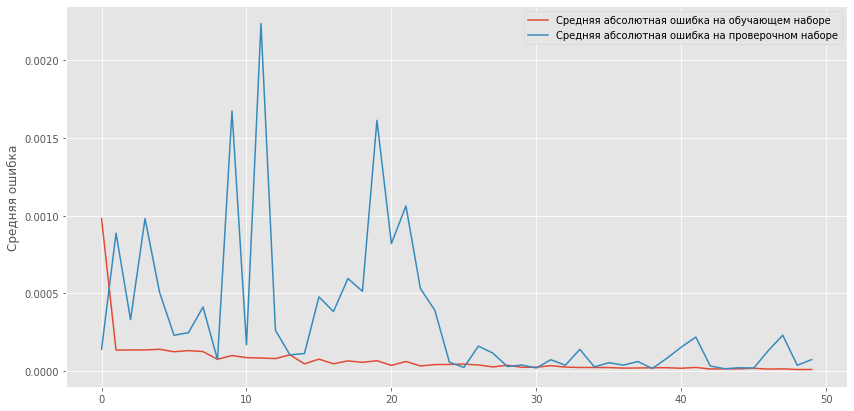

In [107]:
#Выводим графики
plt.figure(figsize=(14,7))
plt.plot(history.history['loss'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [110]:
def getPred(currModel, xVal, yVal, yScaler):
  # Предсказываем ответ сети по проверочной выборке
  # И возвращаем исходны масштаб данных, до нормализации
  predVal = yScaler.inverse_transform(currModel.predict(xVal))
  yValUnscaled = yScaler.inverse_transform(yVal)
  
  return (predVal, yValUnscaled)

In [112]:
def showPredict(start, step, channel, predVal, yValUnscaled):
  plt.figure(figsize=(22,6))
  plt.plot(predVal[start:start+step, 0],
           label='Прогноз')
  plt.plot(yValUnscaled[start:start+step, channel], 
           label='Базовый ряд')
  plt.xlabel('Время')
  plt.ylabel('Значение Close')
  plt.legend()
  plt.show()

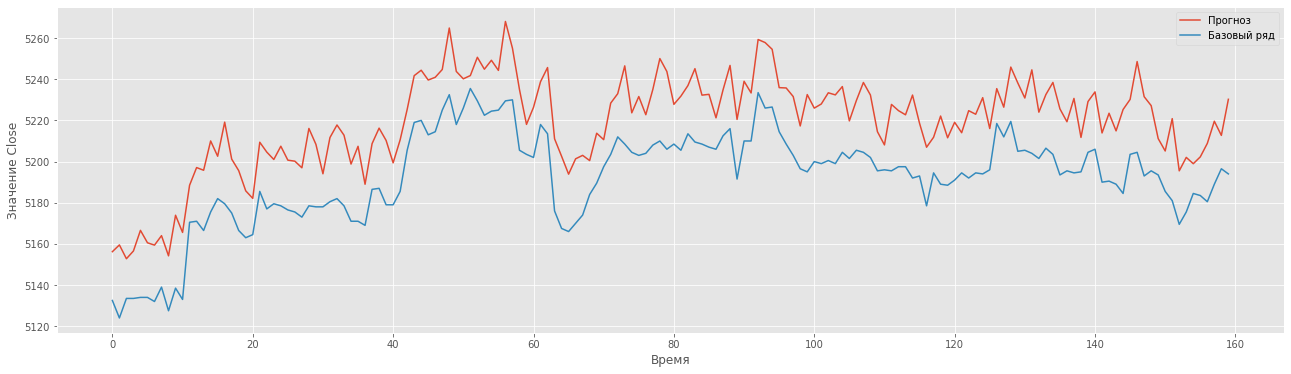

In [113]:
#Прогнозируем данные текущей сетью
currModel = modelD #Выбираем текущую модель
(predVal, yValUnscaled) = getPred(currModel, custom_x_test, custom_y_test, y_scaler) #Прогнозируем данные

#Отображаем графики
showPredict(0, 160, 0, predVal, yValUnscaled)

In [114]:
# Функция расёта корреляции дух одномерных векторов
def correlate(a, b):
  # Рассчитываем основные показатели
  ma = a.mean() # Среднее значение первого вектора
  mb = b.mean() # Среднее значение второго вектора
  mab = (a*b).mean() # Среднее значение произведения векторов
  sa = a.std() # Среднеквадратичное отклонение первого вектора
  sb = b.std() # Среднеквадратичное отклонение второго вектора
  
  #Рассчитываем корреляцию
  val = 1
  if ((sa>0) & (sb>0)):
    val = (mab-ma*mb)/(sa*sb)
  return val

# Функция рисуем корреляцию прогнозированного сигнала с правильным
# Смещая на различное количество шагов назад
# Для проверки появления эффекта автокорреляции
# channels - по каким каналам отображать корреляцию
# corrSteps - на какое количество шагов смещать сигнал назад для рассчёта корреляции
def showCorr(channels, corrSteps, predVal, yValUnscaled):
  # Проходим по всем каналам
  for ch in channels:
    corr = [] # Создаём пустой лист, в нём будут корреляции при смезении на i рагов обратно
    yLen = yValUnscaled.shape[0] # Запоминаем размер проверочной выборки

      # Постепенно увеличикаем шаг, насколько смещаем сигнал для проверки автокорреляции
    for i in range(corrSteps):
      # Получаем сигнал, смещённый на i шагов назад
      # predVal[i:, ch]
      # Сравниваем его с верными ответами, без смещения назад
      # yValUnscaled[:yLen-i,ch]
      # Рассчитываем их корреляцию и добавляем в лист
      corr.append(correlate(yValUnscaled[:yLen-i,ch], predVal[i:, 0]))

    own_corr = [] # Создаём пустой лист, в нём будут корреляции при смезении на i рагов обратно

      # Постепенно увеличикаем шаг, насколько смещаем сигнал для проверки автокорреляции
    for i in range(corrSteps):
      # Получаем сигнал, смещённый на i шагов назад
      # predVal[i:, ch]
      # Сравниваем его с верными ответами, без смещения назад
      # yValUnscaled[:yLen-i,ch]
      # Рассчитываем их корреляцию и добавляем в лист
      own_corr.append(correlate(yValUnscaled[:yLen-i,ch], yValUnscaled[i:, ch]))

    # Отображаем график коррелций для данного шага
    plt.figure(figsize=(14,7))
    plt.plot(corr, label='Предсказание на ' + str(ch+1) + ' шаг')
    plt.plot(own_corr, label='Эталон')

  plt.xlabel('Время')
  plt.ylabel('Значение')
  plt.legend()
  plt.show()

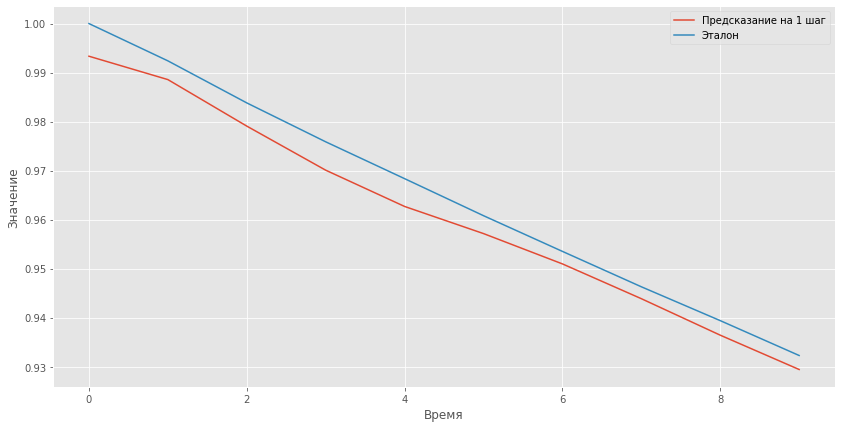

In [115]:
#Отображаем корреляцию
#Используем выходной канал - только open
#Проверяем корреляцию на глубину 60 шагов
showCorr([0], 10, predVal, yValUnscaled)

In [118]:
#Компилируем
modelD.compile(loss="mse", optimizer=Adam(lr=1e-5))
#Запускаем обучение
history = modelD.fit(
                    custom_x_train, 
                    custom_y_train,
                    epochs=50, 
                    verbose=1, 
                    validation_split=0.15
                    )

Epoch 1/50
599/599 [==============================] - 9s 14ms/step - loss: 3.3209e-06 - val_loss: 1.3373e-05
Epoch 2/50
599/599 [==============================] - 8s 13ms/step - loss: 3.0254e-06 - val_loss: 2.3372e-05
Epoch 3/50
599/599 [==============================] - 8s 13ms/step - loss: 2.7242e-06 - val_loss: 2.5450e-05
Epoch 4/50
599/599 [==============================] - 8s 13ms/step - loss: 2.6963e-06 - val_loss: 1.3846e-05
Epoch 5/50
599/599 [==============================] - 8s 13ms/step - loss: 2.7007e-06 - val_loss: 1.4259e-05
Epoch 6/50
599/599 [==============================] - 7s 13ms/step - loss: 2.6334e-06 - val_loss: 1.6587e-05
Epoch 7/50
599/599 [==============================] - 8s 13ms/step - loss: 2.5182e-06 - val_loss: 4.3870e-05
Epoch 8/50
599/599 [==============================] - 8s 13ms/step - loss: 2.5913e-06 - val_loss: 3.0783e-05
Epoch 9/50
599/599 [==============================] - 8s 13ms/step - loss: 2.5548e-06 - val_loss: 3.2001e-05
Epoch 10/50
599/599

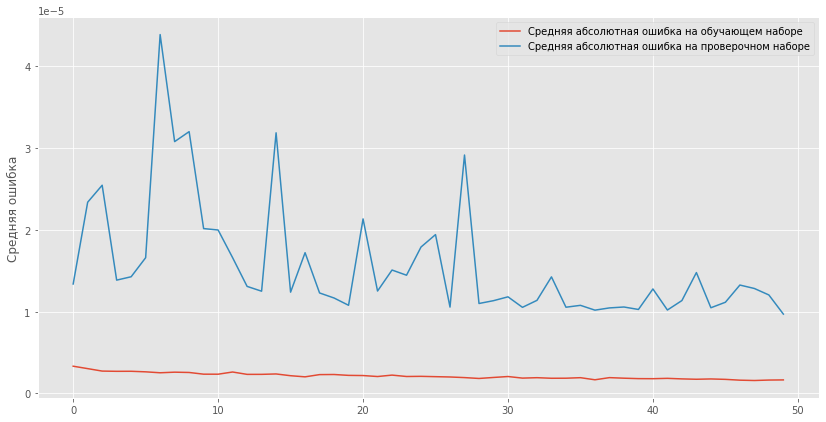

In [119]:
#Выводим графики
plt.figure(figsize=(14,7))
plt.plot(history.history['loss'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

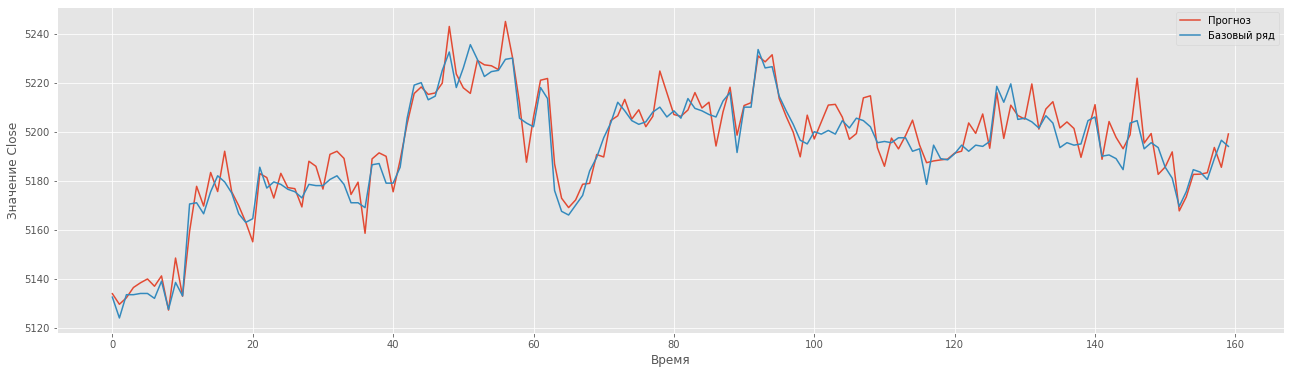

In [120]:
#Прогнозируем данные текущей сетью
currModel = modelD #Выбираем текущую модель
(predVal, yValUnscaled) = getPred(currModel, custom_x_test, custom_y_test, y_scaler) #Прогнозируем данные

#Отображаем графики
showPredict(0, 160, 0, predVal, yValUnscaled)

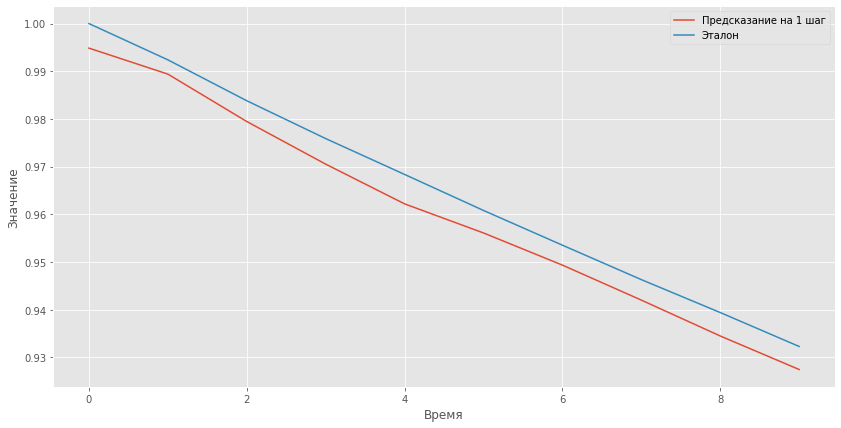

In [121]:
#Отображаем корреляцию
#Используем выходной канал - только open
#Проверяем корреляцию на глубину 60 шагов
showCorr([0], 10, predVal, yValUnscaled)

In [122]:
#Компилируем
modelD.compile(loss="mse", optimizer=Adam(lr=1e-6))
#Запускаем обучение
history = modelD.fit(
                    custom_x_train, 
                    custom_y_train,
                    epochs=50, 
                    verbose=1, 
                    validation_split=0.15
                    )

Epoch 1/50
599/599 [==============================] - 8s 13ms/step - loss: 1.1898e-06 - val_loss: 9.7060e-06
Epoch 2/50
599/599 [==============================] - 7s 12ms/step - loss: 1.1615e-06 - val_loss: 1.0936e-05
Epoch 3/50
599/599 [==============================] - 7s 12ms/step - loss: 1.1731e-06 - val_loss: 1.1626e-05
Epoch 4/50
599/599 [==============================] - 8s 13ms/step - loss: 1.1775e-06 - val_loss: 1.0203e-05
Epoch 5/50
599/599 [==============================] - 7s 12ms/step - loss: 1.1634e-06 - val_loss: 1.0130e-05
Epoch 6/50
599/599 [==============================] - 8s 13ms/step - loss: 1.1759e-06 - val_loss: 1.0568e-05
Epoch 7/50
599/599 [==============================] - 8s 13ms/step - loss: 1.1445e-06 - val_loss: 1.0194e-05
Epoch 8/50
599/599 [==============================] - 8s 13ms/step - loss: 1.1762e-06 - val_loss: 1.0171e-05
Epoch 9/50
599/599 [==============================] - 8s 13ms/step - loss: 1.1559e-06 - val_loss: 9.9616e-06
Epoch 10/50
599/599

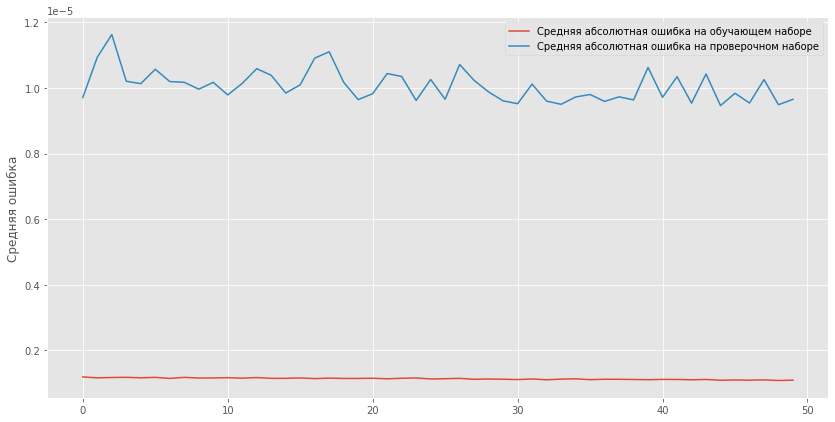

In [123]:
#Выводим графики
plt.figure(figsize=(14,7))
plt.plot(history.history['loss'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

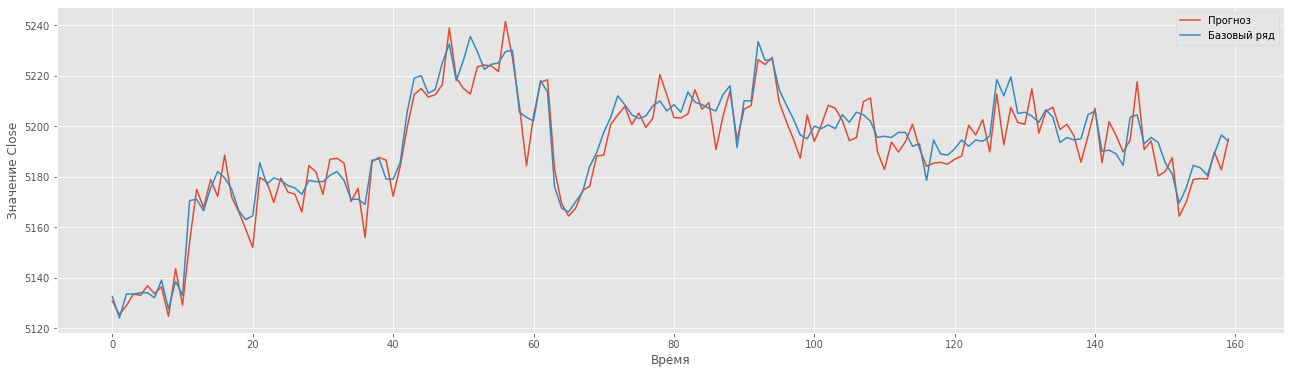

In [124]:
#Прогнозируем данные текущей сетью
currModel = modelD #Выбираем текущую модель
(predVal, yValUnscaled) = getPred(currModel, custom_x_test, custom_y_test, y_scaler) #Прогнозируем данные

#Отображаем графики
showPredict(0, 160, 0, predVal, yValUnscaled)

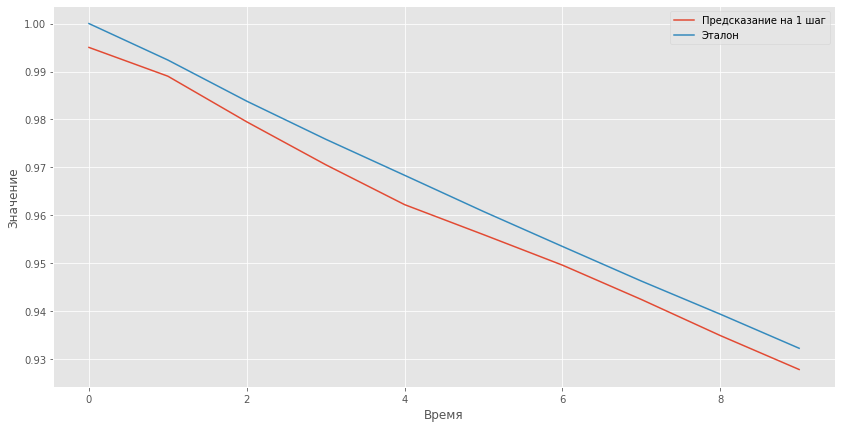

In [125]:
#Отображаем корреляцию
#Используем выходной канал - только open
#Проверяем корреляцию на глубину 60 шагов
showCorr([0], 10, predVal, yValUnscaled)

Результаты отличные, автокорреляция не наблюдается, ошибку на проверочном наборе удалось сократить путем понижения learning rate. Надо сказать, что модель прекрасно предсказывает тренд

Попробуем другие архитектуры, вдруг, удастся еще улучшить результаты?

In [126]:
#Создаём нейронку номер 2
modelD_2 = Sequential()
modelD_2.add(Flatten(input_shape = (SEQ_LEN,50)))
modelD_2.add(Dense(150, activation="relu" )) 
modelD_2.add(Dense(1, activation="linear"))

#Компилируем
modelD_2.compile(loss="mse", optimizer=Adam(lr=1e-4))

modelD_2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 10000)             0         
                                                                 
 dense_6 (Dense)             (None, 150)               1500150   
                                                                 
 dense_7 (Dense)             (None, 1)                 151       
                                                                 
Total params: 1,500,301
Trainable params: 1,500,301
Non-trainable params: 0
_________________________________________________________________


In [127]:
#Компилируем
modelD_2.compile(loss="mse", optimizer=Adam(lr=1e-4))
#Запускаем обучение
history = modelD_2.fit(
                    custom_x_train, 
                    custom_y_train,
                    epochs=50, 
                    verbose=1, 
                    validation_split=0.15
                    )

Epoch 1/50
599/599 [==============================] - 8s 14ms/step - loss: 0.0235 - val_loss: 2.1158e-04
Epoch 2/50
599/599 [==============================] - 8s 13ms/step - loss: 1.7174e-04 - val_loss: 1.4494e-04
Epoch 3/50
599/599 [==============================] - 8s 13ms/step - loss: 1.1791e-04 - val_loss: 1.1245e-04
Epoch 4/50
599/599 [==============================] - 8s 13ms/step - loss: 1.9336e-04 - val_loss: 8.4331e-05
Epoch 5/50
599/599 [==============================] - 8s 13ms/step - loss: 0.0019 - val_loss: 6.0092e-04
Epoch 6/50
599/599 [==============================] - 8s 13ms/step - loss: 7.3869e-04 - val_loss: 0.0042
Epoch 7/50
599/599 [==============================] - 8s 13ms/step - loss: 0.0012 - val_loss: 1.7119e-04
Epoch 8/50
599/599 [==============================] - 8s 13ms/step - loss: 0.0015 - val_loss: 0.0029
Epoch 9/50
599/599 [==============================] - 8s 13ms/step - loss: 7.2874e-04 - val_loss: 1.3428e-04
Epoch 10/50
599/599 [======================

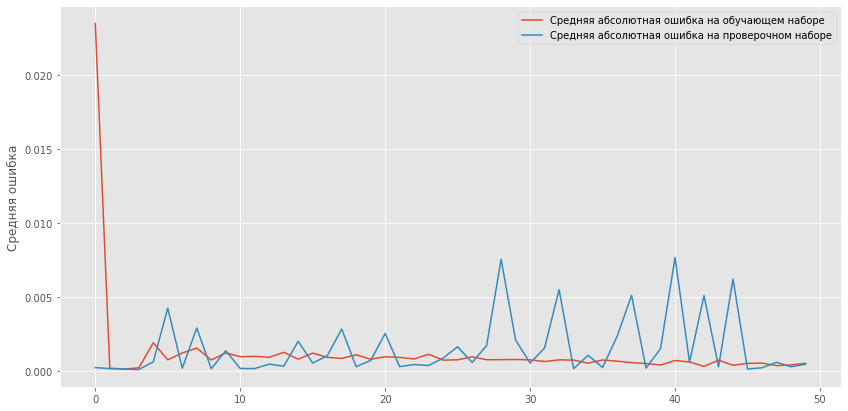

In [128]:
#Выводим графики
plt.figure(figsize=(14,7))
plt.plot(history.history['loss'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

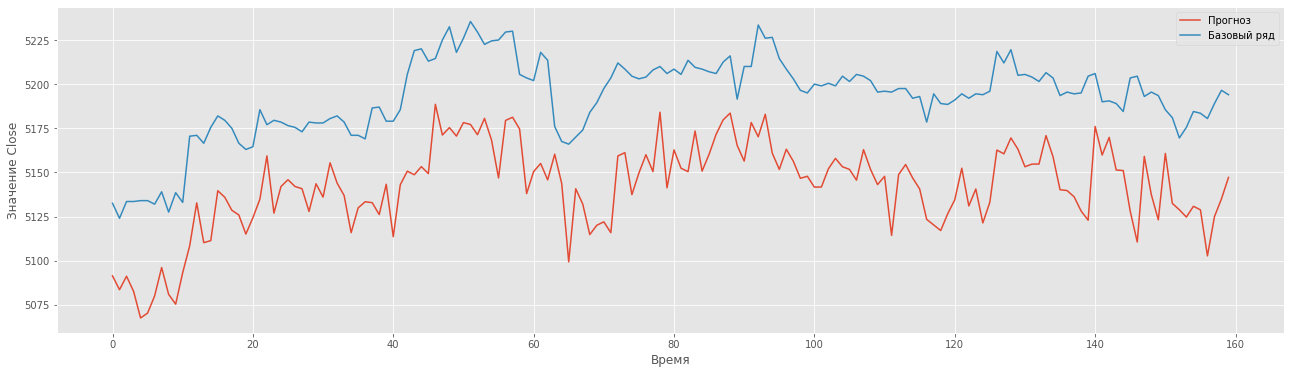

In [129]:
#Прогнозируем данные текущей сетью
currModel = modelD_2 #Выбираем текущую модель
(predVal, yValUnscaled) = getPred(currModel, custom_x_test, custom_y_test, y_scaler) #Прогнозируем данные

#Отображаем графики
showPredict(0, 160, 0, predVal, yValUnscaled)

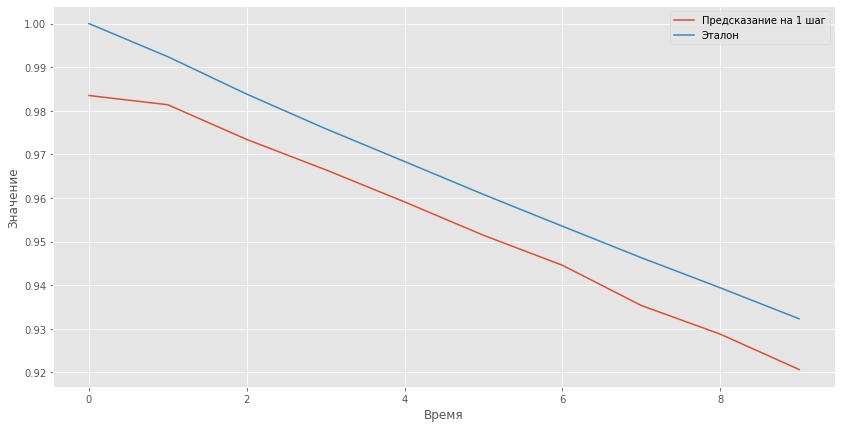

In [130]:
#Отображаем корреляцию
#Используем выходной канал - только open
#Проверяем корреляцию на глубину 60 шагов
showCorr([0], 10, predVal, yValUnscaled)

In [131]:
#Компилируем
modelD_2.compile(loss="mse", optimizer=Adam(lr=1e-5))
#Запускаем обучение
history = modelD_2.fit(
                    custom_x_train, 
                    custom_y_train,
                    epochs=50, 
                    verbose=1, 
                    validation_split=0.15
                    )

Epoch 1/50
599/599 [==============================] - 8s 13ms/step - loss: 3.8028e-05 - val_loss: 2.4383e-04
Epoch 2/50
599/599 [==============================] - 8s 13ms/step - loss: 1.3442e-05 - val_loss: 1.9730e-04
Epoch 3/50
599/599 [==============================] - 8s 13ms/step - loss: 1.7945e-05 - val_loss: 1.8379e-04
Epoch 4/50
599/599 [==============================] - 8s 13ms/step - loss: 1.4294e-05 - val_loss: 2.8871e-04
Epoch 5/50
599/599 [==============================] - 8s 13ms/step - loss: 1.3815e-05 - val_loss: 3.1598e-04
Epoch 6/50
599/599 [==============================] - 8s 13ms/step - loss: 1.4214e-05 - val_loss: 1.2238e-04
Epoch 7/50
599/599 [==============================] - 8s 13ms/step - loss: 1.3862e-05 - val_loss: 2.4245e-04
Epoch 8/50
599/599 [==============================] - 8s 13ms/step - loss: 1.5967e-05 - val_loss: 1.8899e-04
Epoch 9/50
599/599 [==============================] - 8s 13ms/step - loss: 1.3349e-05 - val_loss: 2.5862e-04
Epoch 10/50
599/599

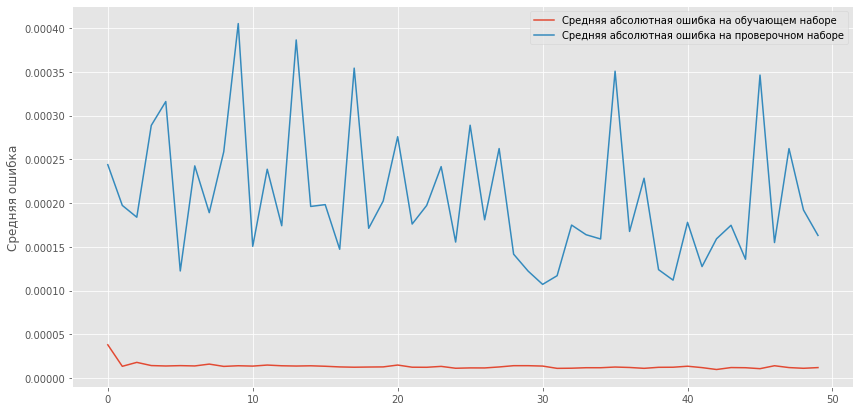

In [132]:
#Выводим графики
plt.figure(figsize=(14,7))
plt.plot(history.history['loss'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

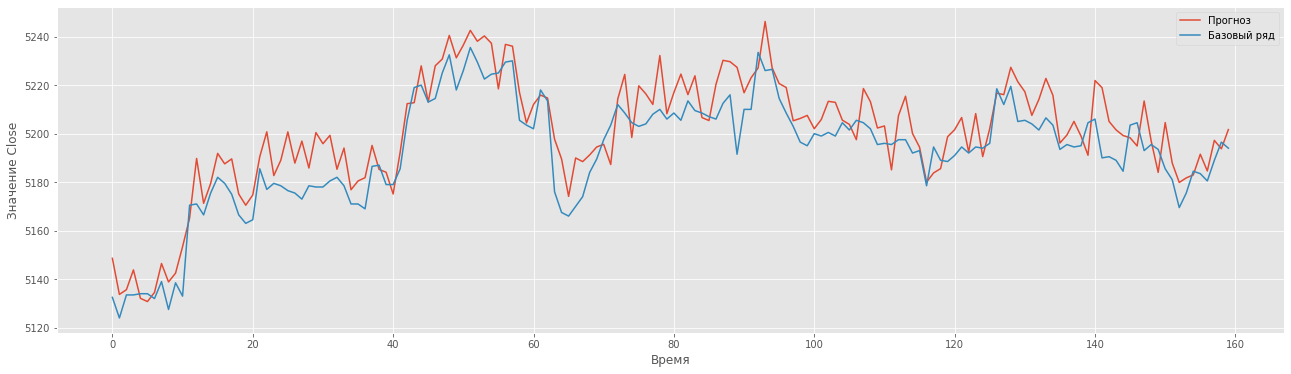

In [133]:
#Прогнозируем данные текущей сетью
currModel = modelD_2 #Выбираем текущую модель
(predVal, yValUnscaled) = getPred(currModel, custom_x_test, custom_y_test, y_scaler) #Прогнозируем данные

#Отображаем графики
showPredict(0, 160, 0, predVal, yValUnscaled)

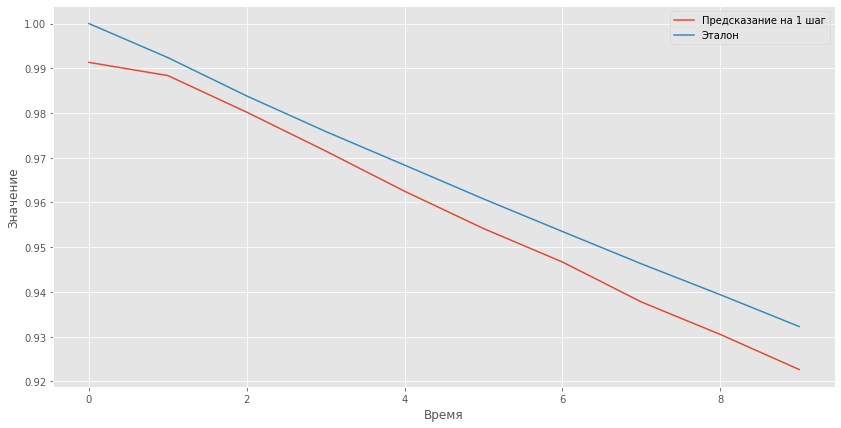

In [134]:
#Отображаем корреляцию
#Используем выходной канал - только open
#Проверяем корреляцию на глубину 60 шагов
showCorr([0], 10, predVal, yValUnscaled)

In [135]:
#Компилируем
modelD_2.compile(loss="mse", optimizer=Adam(lr=1e-6))
#Запускаем обучение
history = modelD_2.fit(
                    custom_x_train, 
                    custom_y_train,
                    epochs=50, 
                    verbose=1, 
                    validation_split=0.15
                    )

Epoch 1/50
599/599 [==============================] - 8s 13ms/step - loss: 4.8295e-06 - val_loss: 2.0566e-04
Epoch 2/50
599/599 [==============================] - 8s 13ms/step - loss: 4.6335e-06 - val_loss: 1.7793e-04
Epoch 3/50
599/599 [==============================] - 8s 13ms/step - loss: 4.7696e-06 - val_loss: 1.8687e-04
Epoch 4/50
599/599 [==============================] - 8s 13ms/step - loss: 4.8558e-06 - val_loss: 1.9071e-04
Epoch 5/50
599/599 [==============================] - 8s 13ms/step - loss: 4.7270e-06 - val_loss: 1.6605e-04
Epoch 6/50
599/599 [==============================] - 8s 13ms/step - loss: 4.6874e-06 - val_loss: 1.6797e-04
Epoch 7/50
599/599 [==============================] - 8s 13ms/step - loss: 4.7026e-06 - val_loss: 2.0092e-04
Epoch 8/50
599/599 [==============================] - 8s 13ms/step - loss: 4.8856e-06 - val_loss: 2.1234e-04
Epoch 9/50
599/599 [==============================] - 8s 13ms/step - loss: 4.5926e-06 - val_loss: 1.6051e-04
Epoch 10/50
599/599

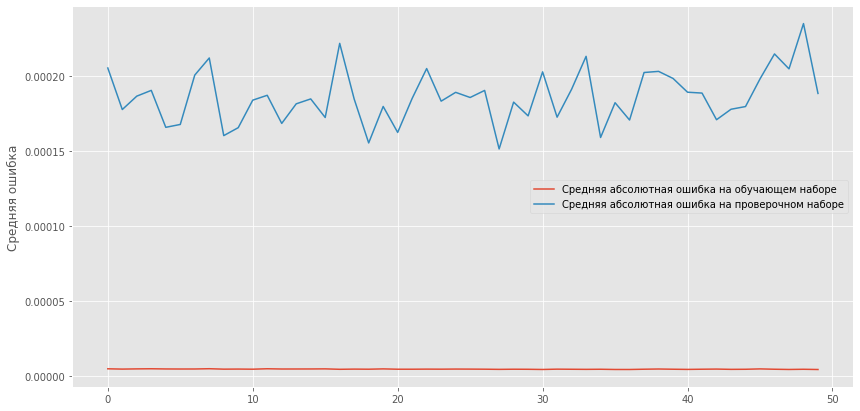

In [136]:
#Выводим графики
plt.figure(figsize=(14,7))
plt.plot(history.history['loss'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

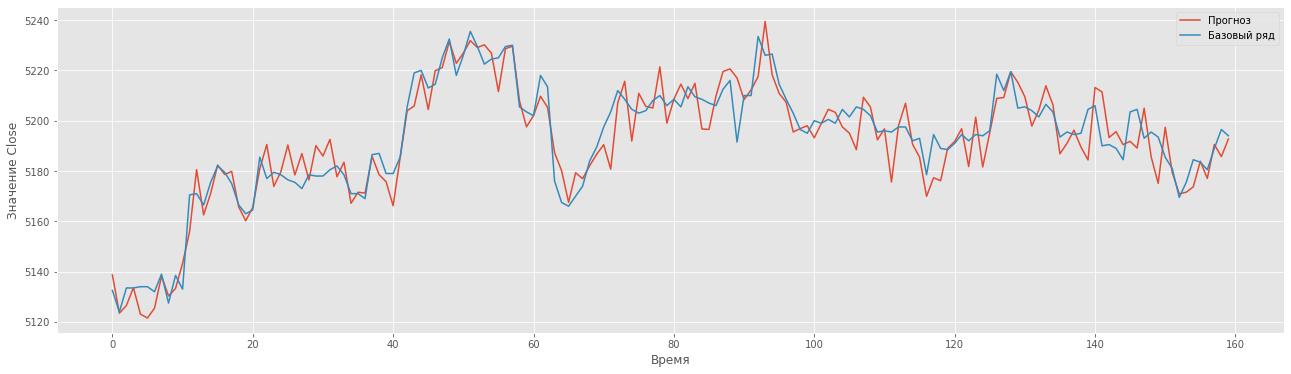

In [137]:
#Прогнозируем данные текущей сетью
currModel = modelD_2 #Выбираем текущую модель
(predVal, yValUnscaled) = getPred(currModel, custom_x_test, custom_y_test, y_scaler) #Прогнозируем данные

#Отображаем графики
showPredict(0, 160, 0, predVal, yValUnscaled)

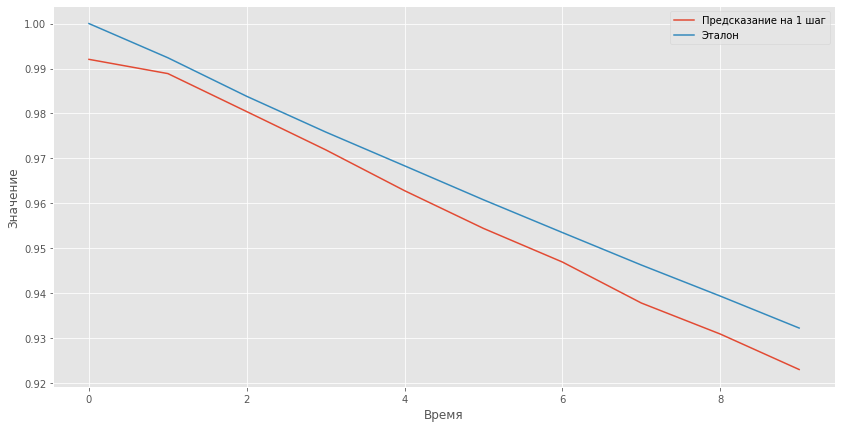

In [138]:
#Отображаем корреляцию
#Используем выходной канал - только open
#Проверяем корреляцию на глубину 60 шагов
showCorr([0], 10, predVal, yValUnscaled)

In [139]:
modelC = Sequential()

modelC.add(Conv1D(64, 5, input_shape = (SEQ_LEN,50), activation="relu"))
modelC.add(Conv1D(64, 5, activation="relu"))
modelC.add(MaxPooling1D())
modelC.add(Flatten())
modelC.add(Dense(100, activation="relu"))
modelC.add(Dense(1, activation="linear"))

modelC.compile(loss="mse", optimizer=Adam(lr=1e-4))

modelC.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 196, 64)           16064     
                                                                 
 conv1d_1 (Conv1D)           (None, 192, 64)           20544     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 96, 64)           0         
 )                                                               
                                                                 
 flatten_4 (Flatten)         (None, 6144)              0         
                                                                 
 dense_8 (Dense)             (None, 100)               614500    
                                                                 
 dense_9 (Dense)             (None, 1)                 101       
                                                      

In [142]:
history = modelC.fit(custom_x_train, 
                    custom_y_train,
                    epochs=50, 
                    verbose=1,
                    validation_split=0.15)

Epoch 1/50
599/599 [==============================] - 29s 47ms/step - loss: 0.0017 - val_loss: 1.6959e-04
Epoch 2/50
599/599 [==============================] - 28s 47ms/step - loss: 1.2962e-04 - val_loss: 1.5287e-04
Epoch 3/50
599/599 [==============================] - 28s 47ms/step - loss: 9.4554e-05 - val_loss: 5.1567e-05
Epoch 4/50
599/599 [==============================] - 28s 47ms/step - loss: 8.6825e-05 - val_loss: 1.4338e-04
Epoch 5/50
599/599 [==============================] - 28s 47ms/step - loss: 6.2975e-05 - val_loss: 4.2958e-05
Epoch 6/50
599/599 [==============================] - 28s 47ms/step - loss: 5.3936e-05 - val_loss: 3.2845e-04
Epoch 7/50
599/599 [==============================] - 28s 47ms/step - loss: 5.3022e-05 - val_loss: 5.0414e-05
Epoch 8/50
599/599 [==============================] - 28s 47ms/step - loss: 4.5053e-05 - val_loss: 1.5677e-04
Epoch 9/50
599/599 [==============================] - 28s 47ms/step - loss: 3.0890e-05 - val_loss: 1.9507e-04
Epoch 10/50
59

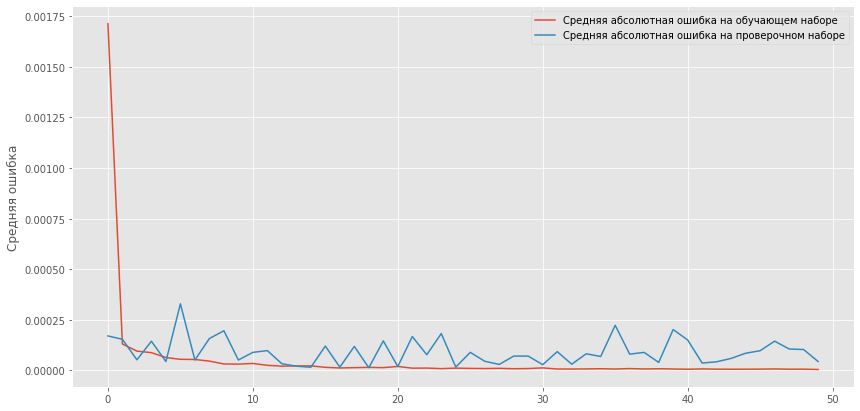

In [143]:
#Выводим графики
plt.figure(figsize=(14,7))
plt.plot(history.history['loss'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

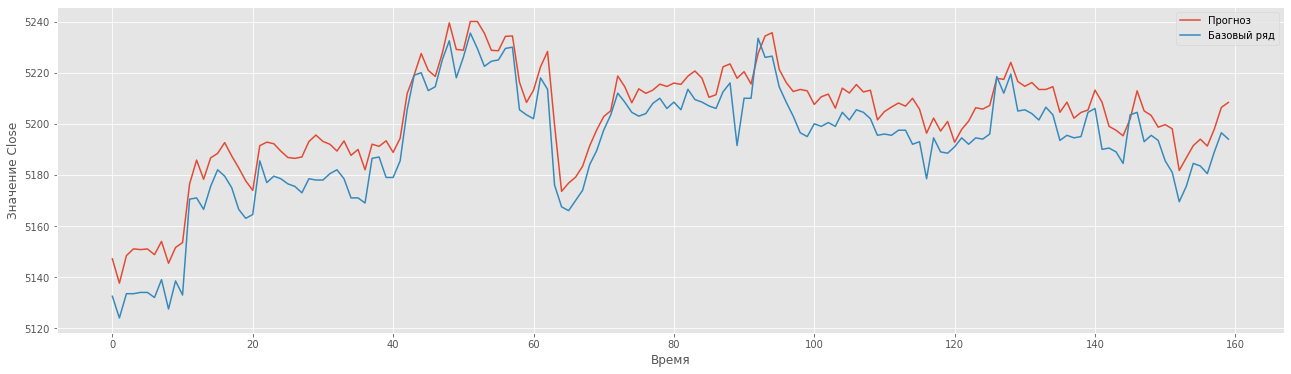

In [144]:
#Прогнозируем данные текущей сетью
currModel = modelC #Выбираем текущую модель
(predVal, yValUnscaled) = getPred(currModel, custom_x_test, custom_y_test, y_scaler) #Прогнозируем данные

#Отображаем графики
showPredict(0, 160, 0, predVal, yValUnscaled)

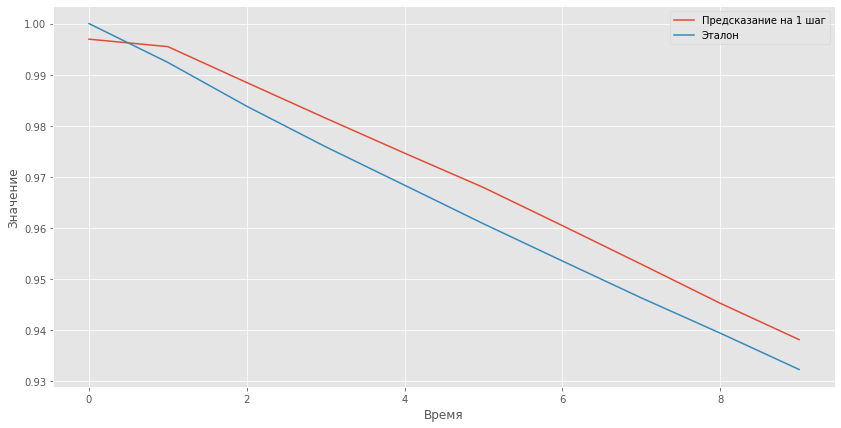

In [145]:
#Отображаем корреляцию
#Используем выходной канал - только open
#Проверяем корреляцию на глубину 60 шагов
showCorr([0], 10, predVal, yValUnscaled)

нам удалось достичь отличных результатов, отсутствие корреляции, довольно-таки точное предсказание модели.
На этом, наверное, с экспериментами следует остановиться, хотя по идее можно было бы и продолжить.